In [2]:
!pip install folium


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from geopy.distance import geodesic
from collections import defaultdict
import folium
import warnings
warnings.filterwarnings('ignore')

In [2]:
# 1. Load data from Excel files
print("Step 1: Loading data from Excel files...")
fleet_df = pd.read_excel('fleet.xlsx')
outlets_df = pd.read_excel('outlets.xlsx', sheet_name='outlets')
depots_df = pd.read_excel('depots.xlsx')

Step 1: Loading data from Excel files...


In [3]:
# 2. Data preprocessing
print("Step 2: Preprocessing data...")
# Convert coordinates to latitude and longitude
outlets_df[['Latitude', 'Longitude']] = outlets_df['Coordinates'].str.split(',', expand=True).astype(float)
depots_df[['Latitude', 'Longitude']] = depots_df['Coordinates'].str.split(',', expand=True).astype(float)

# Fix column names in fleet_df
fleet_df.columns = fleet_df.columns.astype(str)
truck_capacities = ['900', '850', '700', '550', '350']

# Calculate total trucks and capacity per depot
depot_fleet = {}
for _, row in fleet_df.iterrows():
    dc_index = row['DC index']
    if pd.notna(dc_index):
        trucks = []
        for cap in truck_capacities:
            if pd.notna(row[cap]) and row[cap] > 0:
                trucks.extend([int(cap)] * int(row[cap]))
        depot_fleet[dc_index] = trucks


Step 2: Preprocessing data...


In [4]:
# 3. Calculate distances between outlets and depots
print("Step 3: Calculating distances between outlets and depots...")
def calculate_distance(lat1, lon1, lat2, lon2):
    return geodesic((lat1, lon1), (lat2, lon2)).km

# Create a distance matrix: outlets x depots
distances = np.zeros((len(outlets_df), len(depots_df)))
for i, outlet in outlets_df.iterrows():
    for j, depot in depots_df.iterrows():
        distances[i, j] = calculate_distance(
            outlet['Latitude'], outlet['Longitude'],
            depot['Latitude'], depot['Longitude']
        )

Step 3: Calculating distances between outlets and depots...


In [5]:
# 4. Find nearest and second nearest depot for each outlet
print("Step 4: Finding nearest and second-nearest depots for each outlet...")
outlet_to_depot = []
for i in range(len(outlets_df)):
    depot_distances = distances[i, :]
    # Get indices of nearest and second nearest depot
    nearest = np.argsort(depot_distances)[:2]
    outlet_to_depot.append({
        'outlet_index': i,
        'nearest_depot': depots_df.iloc[nearest[0]]['Location'],
        'second_nearest_depot': depots_df.iloc[nearest[1]]['Location'],
        'nearest_distance': depot_distances[nearest[0]],
        'second_nearest_distance': depot_distances[nearest[1]]
    })


nearest_depot_df = pd.DataFrame(outlet_to_depot)
outlets_df = pd.merge(outlets_df, nearest_depot_df, left_index=True, right_on='outlet_index')

Step 4: Finding nearest and second-nearest depots for each outlet...


In [6]:
# 5. Calculate volume distribution by region
print("Step 5: Analyzing volume distribution by region...")
# Add region information to outlets based on their nearest depot
outlets_df = outlets_df.merge(
    depots_df[['Location', 'Region']], 
    left_on='nearest_depot', 
    right_on='Location', 
    how='left',
    suffixes=('', '_depot')  # Use custom suffixes to avoid _x, _y naming
)

# Check which column names were created during the merge
print("Columns after merge:", outlets_df.columns.tolist())

# Drop the duplicate location column if it exists
if 'Location_depot' in outlets_df.columns:
    outlets_df.drop('Location_depot', axis=1, inplace=True)

# Calculate average volume by region
region_volume = outlets_df.groupby('Region')['AVG Volume'].sum()
print(f"Total volume by region:\n{region_volume}")


Step 5: Analyzing volume distribution by region...
Columns after merge: ['Outlet No.', 'Market', 'AVG Volume', 'Coordinates', 'Latitude', 'Longitude', 'outlet_index', 'nearest_depot', 'second_nearest_depot', 'nearest_distance', 'second_nearest_distance', 'Location', 'Region']
Total volume by region:
Region
Central     499849.318189
Northern    477960.772649
Western     681709.005091
Name: AVG Volume, dtype: float64


In [7]:
# 6. Balance depots based on capacity and regional demand
print("Step 6: Balancing depot assignments...")
# Calculate available capacity per depot
depot_capacity = {}
for dc_index, trucks in depot_fleet.items():
    capacity = sum(trucks)
    depot_capacity[dc_index] = capacity

# Try to balance volume across depots within regions based on capacity
depot_assigned_volume = {depot: 0 for depot in depot_capacity.keys()}

# Group outlets by region
region_outlets = {region: outlets_df[outlets_df['Region'] == region] for region in outlets_df['Region'].unique()}

# Helper function to assign outlets to depots within a region
def assign_outlets_to_depots(region_df, region_depots):
    depot_indices = [int(loc) for loc in depots_df[depots_df['Region'] == region]['Location']]
    depot_capacities = {idx: depot_capacity.get(idx, 0) for idx in depot_indices}
    depot_volumes = {idx: 0 for idx in depot_indices}
    
    # Sort outlets by volume (descending)
    sorted_outlets = region_df.sort_values('AVG Volume', ascending=False)
    
    assignments = []
    for _, outlet in sorted_outlets.iterrows():
        # Find the least filled depot relative to its capacity
        available_depots = [(d, depot_capacities.get(d, 0), depot_volumes.get(d, 0)) 
                          for d in [outlet['nearest_depot'], outlet['second_nearest_depot']] 
                          if int(d) in depot_indices]
        
        if not available_depots:
            continue
            
        # Sort by current load percentage
        available_depots.sort(key=lambda x: x[2]/x[1] if x[1] > 0 else float('inf'))
        
        # Assign to least loaded depot
        best_depot = int(available_depots[0][0])
        depot_volumes[best_depot] += outlet['AVG Volume']
        
        assignments.append({
            'Outlet No.': outlet['Outlet No.'],
            'Assigned Depot': best_depot,
            'AVG Volume': outlet['AVG Volume'],
            'Market': outlet['Market'],
            'Coordinates': outlet['Coordinates'],
            'Latitude': outlet['Latitude'],
            'Longitude': outlet['Longitude']
        })
    
    return pd.DataFrame(assignments)

# Assign outlets to depots for each region
balanced_outlets = pd.DataFrame()
for region, region_df in region_outlets.items():
    region_depots = depots_df[depots_df['Region'] == region]['Location'].values
    assigned = assign_outlets_to_depots(region_df, region_depots)
    balanced_outlets = pd.concat([balanced_outlets, assigned])

print(f"Assigned {len(balanced_outlets)} outlets to balanced depots")

Step 6: Balancing depot assignments...
Assigned 2293 outlets to balanced depots


In [8]:

# 7. Create route clusters within each depot
print("Step 7: Creating route clusters within each depot...")
def create_depot_clusters(depot_outlets, n_clusters):
    if len(depot_outlets) <= n_clusters:
        # If fewer outlets than clusters, each outlet gets its own cluster
        depot_outlets['Cluster'] = range(len(depot_outlets))
        return depot_outlets
    
    # Use K-means clustering based on geographical location
    coords = depot_outlets[['Latitude', 'Longitude']].values
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    depot_outlets['Cluster'] = kmeans.fit_predict(coords)
    
    return depot_outlets

# Determine number of clusters based on fleet size
depot_clusters = {}
for depot in balanced_outlets['Assigned Depot'].unique():
    depot_id = int(depot)
    depot_outlets = balanced_outlets[balanced_outlets['Assigned Depot'] == depot_id]
    
    # Get available trucks
    trucks = depot_fleet.get(depot_id, [])
    if not trucks:
        continue
        
    # Number of clusters = number of trucks
    n_clusters = len(trucks)
    
    # Create clusters
    depot_outlets = create_depot_clusters(depot_outlets, n_clusters)
    depot_clusters[depot_id] = depot_outlets

Step 7: Creating route clusters within each depot...


In [9]:
# 8. Assign outlets to trucks within each depot
print("Step 8: Assigning outlets to trucks...")
truck_assignments = []

for depot_id, depot_df in depot_clusters.items():
    trucks = depot_fleet.get(depot_id, [])
    if not trucks:
        continue
        
    clusters = depot_df['Cluster'].unique()
    
    # Match clusters to trucks based on capacity and volume
    cluster_volumes = depot_df.groupby('Cluster')['AVG Volume'].sum().reset_index()
    # Sort clusters by volume (descending)
    cluster_volumes = cluster_volumes.sort_values('AVG Volume', ascending=False)
    
    # Sort trucks by capacity (descending)
    trucks = sorted(trucks, reverse=True)
    
    for i, (_, cluster_row) in enumerate(cluster_volumes.iterrows()):
        if i >= len(trucks):
            # More clusters than trucks, assign to the last truck
            truck_idx = len(trucks) - 1
        else:
            truck_idx = i
            
        cluster_outlets = depot_df[depot_df['Cluster'] == cluster_row['Cluster']]
        
        for _, outlet in cluster_outlets.iterrows():
            truck_assignments.append({
                'Depot': depot_id,
                'Truck Index': truck_idx + 1,  # 1-based indexing for readability
                'Truck Capacity': trucks[truck_idx],
                'Outlet No.': outlet['Outlet No.'],
                'AVG Volume': outlet['AVG Volume'],
                'Coordinates': outlet['Coordinates'],
                'Latitude': outlet['Latitude'],
                'Longitude': outlet['Longitude'],
                'Market': outlet['Market']
            })

assignments_df = pd.DataFrame(truck_assignments)

Step 8: Assigning outlets to trucks...


In [10]:
# 9. Calculate truck loads and utilization
print("Step 9: Calculating truck loads and utilization...")
# Calculate total load per truck
truck_loads = assignments_df.groupby(['Depot', 'Truck Index', 'Truck Capacity'])['AVG Volume'].sum().reset_index()
truck_loads['Daily Utilization'] = (truck_loads['AVG Volume'] / truck_loads['Truck Capacity']) * 100
truck_loads['Monthly Utilization'] = truck_loads['Daily Utilization'] / 24  # Divide by 24 operating days per month

Step 9: Calculating truck loads and utilization...


In [11]:
# 10. Optimize routes for each truck
print("Step 10: Optimizing routes for each truck...")
def optimize_route(outlets_df, depot_coords):
    """Simple route optimization using nearest neighbor heuristic"""
    if len(outlets_df) <= 1:
        return outlets_df
    
    # Start from the depot
    current_pos = depot_coords
    route_indices = []
    unvisited = outlets_df.copy()
    
    while len(unvisited) > 0:
        # Find nearest unvisited outlet
        min_dist = float('inf')
        nearest_idx = None
        
        for idx, outlet in unvisited.iterrows():
            dist = calculate_distance(
                current_pos[0], current_pos[1],
                outlet['Latitude'], outlet['Longitude']
            )
            if dist < min_dist:
                min_dist = dist
                nearest_idx = idx
        
        # Add to route and update current position
        route_indices.append(nearest_idx)
        current_pos = (unvisited.loc[nearest_idx, 'Latitude'], unvisited.loc[nearest_idx, 'Longitude'])
        unvisited = unvisited.drop(nearest_idx)
    
    # Return outlets in route order
    return outlets_df.loc[route_indices]

optimized_routes = {}
routes_distances = {}

for depot_id in assignments_df['Depot'].unique():
    depot_coords = depots_df[depots_df['Location'] == depot_id][['Latitude', 'Longitude']].values[0]
    
    for truck_idx in assignments_df[assignments_df['Depot'] == depot_id]['Truck Index'].unique():
        truck_outlets = assignments_df[(assignments_df['Depot'] == depot_id) & 
                                       (assignments_df['Truck Index'] == truck_idx)]
        
        # Skip if no outlets assigned to this truck
        if len(truck_outlets) == 0:
            continue
            
        # Optimize route
        optimized_route = optimize_route(truck_outlets, depot_coords)
        route_key = (depot_id, truck_idx)
        optimized_routes[route_key] = optimized_route
        
        # Calculate route distance
        total_distance = 0
        prev_point = depot_coords
        
        for _, outlet in optimized_route.iterrows():
            current_point = (outlet['Latitude'], outlet['Longitude'])
            total_distance += calculate_distance(prev_point[0], prev_point[1], 
                                               current_point[0], current_point[1])
            prev_point = current_point
        
        # Add return to depot
        total_distance += calculate_distance(prev_point[0], prev_point[1], 
                                           depot_coords[0], depot_coords[1])
        
        routes_distances[route_key] = total_distance

Step 10: Optimizing routes for each truck...


In [12]:
# 11. Calculate monthly mileage
print("Step 11: Calculating monthly mileage...")
# Assuming weekly delivery (visiting all outlets once per week)
weekly_frequency = 1
weekly_distances = {k: v for k, v in routes_distances.items()}
monthly_distances = {k: v * weekly_frequency * 4 for k, v in weekly_distances.items()}  # 4 weeks per month

# Prepare for results
mileage_results = []
for (depot_id, truck_idx), distance in monthly_distances.items():
    # Get truck capacity
    truck_cap = assignments_df[(assignments_df['Depot'] == depot_id) & 
                             (assignments_df['Truck Index'] == truck_idx)]['Truck Capacity'].values[0]
    
    # Get total load
    total_load = assignments_df[(assignments_df['Depot'] == depot_id) & 
                              (assignments_df['Truck Index'] == truck_idx)]['AVG Volume'].sum()
    
    # Get daily and monthly utilization
    daily_util = (total_load / truck_cap) * 100
    monthly_util = daily_util / 24  # 24 operating days
    
    # Get number of outlets served
    n_outlets = len(assignments_df[(assignments_df['Depot'] == depot_id) & 
                                (assignments_df['Truck Index'] == truck_idx)])
    
    mileage_results.append({
        'Depot': depot_id,
        'Truck Index': truck_idx,
        'Truck Capacity': truck_cap,
        'Total Load': total_load,
        'Daily Utilization': daily_util,
        'Monthly Utilization': monthly_util,
        'Monthly Mileage': distance,
        'Outlets Served': n_outlets
    })

mileage_df = pd.DataFrame(mileage_results)

Step 11: Calculating monthly mileage...


In [13]:
# 13. Recalculate routes after rebalancing
print("Step 13: Recalculating routes after rebalancing...")
# Re-run route optimization
optimized_routes = {}
routes_distances = {}

for depot_id in assignments_df['Depot'].unique():
    depot_coords = depots_df[depots_df['Location'] == depot_id][['Latitude', 'Longitude']].values[0]
    
    for truck_idx in assignments_df[assignments_df['Depot'] == depot_id]['Truck Index'].unique():
        truck_outlets = assignments_df[(assignments_df['Depot'] == depot_id) & 
                                       (assignments_df['Truck Index'] == truck_idx)]
        
        # Skip if no outlets assigned to this truck
        if len(truck_outlets) == 0:
            continue
            
        # Optimize route
        optimized_route = optimize_route(truck_outlets, depot_coords)
        route_key = (depot_id, truck_idx)
        optimized_routes[route_key] = optimized_route
        
        # Calculate route distance
        total_distance = 0
        prev_point = depot_coords
        
        for _, outlet in optimized_route.iterrows():
            current_point = (outlet['Latitude'], outlet['Longitude'])
            total_distance += calculate_distance(prev_point[0], prev_point[1], 
                                               current_point[0], current_point[1])
            prev_point = current_point
        
        # Add return to depot
        total_distance += calculate_distance(prev_point[0], prev_point[1], 
                                           depot_coords[0], depot_coords[1])
        
        routes_distances[route_key] = total_distance

# Recalculate monthly mileage and statistics
weekly_distances = {k: v for k, v in routes_distances.items()}
monthly_distances = {k: v * weekly_frequency * 4 for k, v in weekly_distances.items()}

# Final results
final_results = []
for (depot_id, truck_idx), distance in monthly_distances.items():
    # Get truck capacity
    truck_cap = assignments_df[(assignments_df['Depot'] == depot_id) & 
                             (assignments_df['Truck Index'] == truck_idx)]['Truck Capacity'].values[0]
    
    # Get total load
    total_load = assignments_df[(assignments_df['Depot'] == depot_id) & 
                              (assignments_df['Truck Index'] == truck_idx)]['AVG Volume'].sum()
    
    # Get daily and monthly utilization
    daily_util = (total_load / truck_cap) * 100
    monthly_util = daily_util / 24  # 24 operating days
    
    # Get number of outlets served
    n_outlets = len(assignments_df[(assignments_df['Depot'] == depot_id) & 
                                (assignments_df['Truck Index'] == truck_idx)])
    
    # Get outlet numbers
    outlet_numbers = assignments_df[(assignments_df['Depot'] == depot_id) & 
                                 (assignments_df['Truck Index'] == truck_idx)]['Outlet No.'].tolist()
    
    final_results.append({
        'Depot': depot_id,
        'Truck Index': truck_idx,
        'Truck Capacity': truck_cap,
        'Total Load': total_load,
        'Daily Utilization': daily_util,
        'Monthly Utilization': monthly_util,
        'Monthly Mileage': distance,
        'Outlets Served': n_outlets,
        'Outlet Numbers': outlet_numbers
    })

final_results_df = pd.DataFrame(final_results)

Step 13: Recalculating routes after rebalancing...


Step 14: Visualizing results...


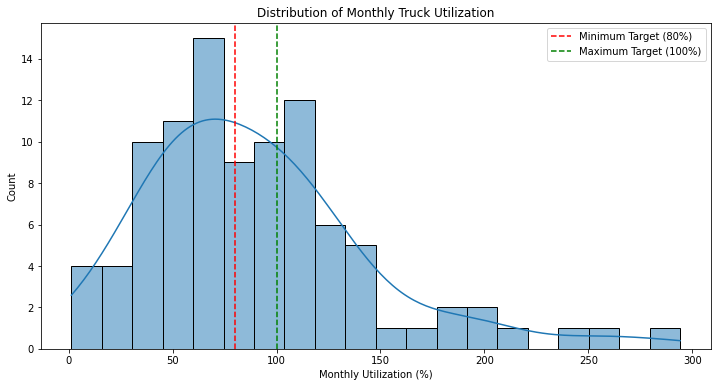

In [15]:
# 14. Visualize results
print("Step 14: Visualizing results...")
# 1. Distribution of truck utilization
plt.figure(figsize=(12, 6))
sns.histplot(final_results_df['Monthly Utilization'], bins=20, kde=True)
plt.axvline(x=80, color='r', linestyle='--', label='Minimum Target (80%)')
plt.axvline(x=100, color='g', linestyle='--', label='Maximum Target (100%)')
plt.title('Distribution of Monthly Truck Utilization')
plt.xlabel('Monthly Utilization (%)')
plt.ylabel('Count')
plt.legend()
plt.savefig('monthly_utilization_distribution.png')
plt.show()

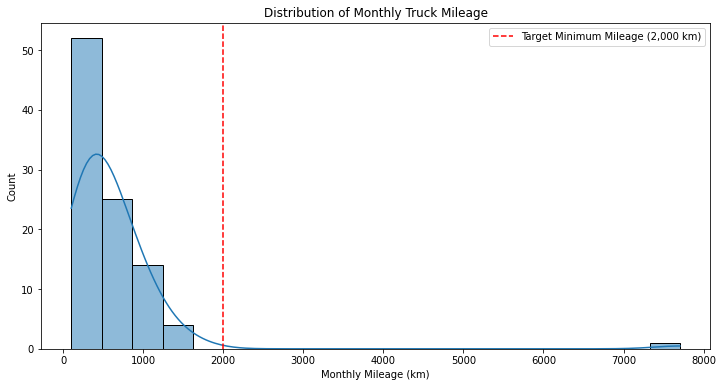

In [16]:
# 2. Distribution of monthly mileage
plt.figure(figsize=(12, 6))
sns.histplot(final_results_df['Monthly Mileage'], bins=20, kde=True)
plt.axvline(x=2000, color='r', linestyle='--', label='Target Minimum Mileage (2,000 km)')
plt.title('Distribution of Monthly Truck Mileage')
plt.xlabel('Monthly Mileage (km)')
plt.ylabel('Count')
plt.legend()
plt.savefig('monthly_mileage_distribution.png')
plt.show()

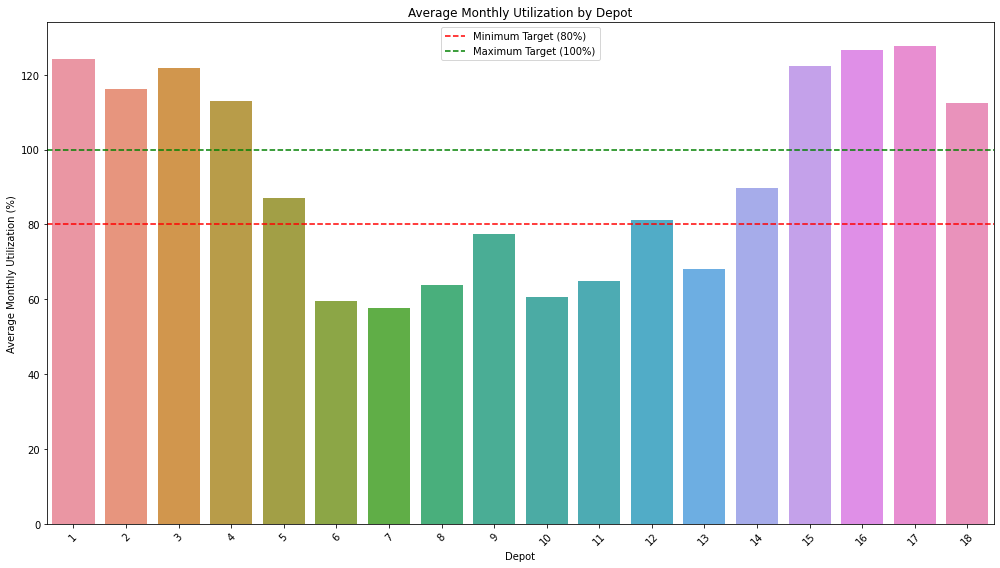

In [17]:
# 3. Utilization by depot
plt.figure(figsize=(14, 8))
avg_utilization = final_results_df.groupby('Depot')['Monthly Utilization'].mean().reset_index()
sns.barplot(x='Depot', y='Monthly Utilization', data=avg_utilization)
plt.axhline(y=80, color='r', linestyle='--', label='Minimum Target (80%)')
plt.axhline(y=100, color='g', linestyle='--', label='Maximum Target (100%)')
plt.title('Average Monthly Utilization by Depot')
plt.xlabel('Depot')
plt.ylabel('Average Monthly Utilization (%)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.savefig('depot_utilization.png')
plt.show()

In [18]:
# 4. Map visualization of depot routes
for depot_id in final_results_df['Depot'].unique():
    if depot_id in [1, 3, 10]:  # Example: create maps for specific depots
        depot_coords = depots_df[depots_df['Location'] == depot_id][['Latitude', 'Longitude']].values[0]
        
        m = folium.Map(location=depot_coords, zoom_start=10)
        folium.Marker(
            depot_coords, 
            popup=f"Depot {depot_id}",
            icon=folium.Icon(color='black', icon='home')
        ).add_to(m)
        
        # Add routes for this depot
        for truck_idx in final_results_df[final_results_df['Depot'] == depot_id]['Truck Index']:
            route_key = (depot_id, truck_idx)
            if route_key in optimized_routes:
                truck_route = optimized_routes[route_key]
                
                # Add outlets as markers
                for _, outlet in truck_route.iterrows():
                    folium.CircleMarker(
                        [outlet['Latitude'], outlet['Longitude']],
                        radius=5,
                        popup=f"Outlet {outlet['Outlet No.']}",
                        color=f'#{hash(truck_idx) % 0xFFFFFF:06x}',  # Color based on truck
                        fill=True
                    ).add_to(m)
                
                # Add route lines
                route_points = [[outlet['Latitude'], outlet['Longitude']] for _, outlet in truck_route.iterrows()]
                # Add depot at start and end
                route_points = [depot_coords.tolist()] + route_points + [depot_coords.tolist()]
                
                folium.PolyLine(
                    route_points,
                    color=f'#{hash(truck_idx) % 0xFFFFFF:06x}',
                    weight=2,
                    opacity=0.7,
                    popup=f"Truck {truck_idx}"
                ).add_to(m)
        
        m.save(f'depot_{depot_id}_routes.html')

In [25]:
# 15. Print final results
print("Step 15: Printing final results...")
# Overall statistics
print("\nOverall Statistics:")
print(f"Total trucks used: {len(final_results_df)}")
print(f"Average monthly utilization: {final_results_df['Monthly Utilization'].mean():.2f}%")
print(f"Average monthly mileage: {final_results_df['Monthly Mileage'].mean():.2f} km")

trucks_below_min_mileage = len(final_results_df[final_results_df['Monthly Mileage'] < 2000])
print(f"Trucks below 2,000 km monthly mileage: {trucks_below_min_mileage}")

trucks_below_min_util = len(final_results_df[final_results_df['Monthly Utilization'] < 80])
trucks_above_max_util = len(final_results_df[final_results_df['Monthly Utilization'] > 100])
print(f"Trucks below 80% monthly utilization: {trucks_below_min_util}")
print(f"Trucks above 100% monthly utilization: {trucks_above_max_util}")

# Print final truck assignments by depot
print("\nFinal Truck Assignments by Depot:")
for depot_id in final_results_df['Depot'].unique():
    print(f"\nDepot {depot_id}:")
    depot_trucks = final_results_df[final_results_df['Depot'] == depot_id].sort_values('Truck Index')
    
    for _, truck in depot_trucks.iterrows():
        print(f"  Truck {int(truck['Truck Index'])} (Capacity: {int(truck['Truck Capacity'])}):")
        print(f"    Load: {truck['Total Load']:.2f} units")
        
        print(f"    Monthly Utilization: {truck['Monthly Utilization']:.2f}%")
        print(f"    Est. Monthly Mileage: {truck['Monthly Mileage']:.2f} km")
        print(f"    Assigned Outlets: {truck['Outlets Served']}")
        print(f"    Outlet Numbers: {truck['Outlet Numbers']}")

print("\nOptimization process completed successfully!")

Step 15: Printing final results...

Overall Statistics:
Total trucks used: 95
Average monthly utilization: 91.42%
Average monthly mileage: 614.28 km
Trucks below 2,000 km monthly mileage: 94
Trucks below 80% monthly utilization: 49
Trucks above 100% monthly utilization: 31

Final Truck Assignments by Depot:

Depot 4:
  Truck 1 (Capacity: 900):
    Load: 56809.77 units
    Monthly Utilization: 263.01%
    Est. Monthly Mileage: 404.61 km
    Assigned Outlets: 80
    Outlet Numbers: [1008, 772, 819, 761, 815, 731, 762, 758, 1083, 741, 479, 40, 1216, 831, 545, 12, 557, 786, 857, 552, 734, 549, 1293, 562, 520, 84, 577, 859, 354, 574, 229, 763, 522, 887, 518, 98, 509, 374, 86, 582, 883, 581, 1092, 756, 528, 886, 773, 841, 885, 599, 132, 794, 502, 998, 888, 598, 862, 551, 727, 975, 517, 870, 431, 506, 748, 570, 799, 744, 733, 603, 749, 537, 565, 460, 434, 533, 323, 596, 858, 676]
  Truck 2 (Capacity: 850):
    Load: 21685.07 units
    Monthly Utilization: 106.30%
    Est. Monthly Mileage: 434

In [19]:
pip install tabulate

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [20]:
# 15. Print final results
print("Step 15: Printing final results...")
# Import tabulate for nice table formatting
from tabulate import tabulate

# Overall statistics
print("\nOverall Statistics:")
print(f"Total trucks used: {len(final_results_df)}")
print(f"Average monthly utilization: {final_results_df['Monthly Utilization'].mean():.2f}%")
print(f"Average monthly mileage: {final_results_df['Monthly Mileage'].mean():.2f} km")

trucks_below_min_mileage = len(final_results_df[final_results_df['Monthly Mileage'] < 2000])
print(f"Trucks below 2,000 km monthly mileage: {trucks_below_min_mileage}")

trucks_below_min_util = len(final_results_df[final_results_df['Monthly Utilization'] < 80])
trucks_above_max_util = len(final_results_df[final_results_df['Monthly Utilization'] > 100])
print(f"Trucks below 80% monthly utilization: {trucks_below_min_util}")
print(f"Trucks above 100% monthly utilization: {trucks_above_max_util}")

# Print final truck assignments by depot as tables
print("\nFinal Truck Assignments by Depot:")
for depot_id in sorted(final_results_df['Depot'].unique()):
    print(f"\n== Depot {depot_id} ==")
    depot_trucks = final_results_df[final_results_df['Depot'] == depot_id].sort_values('Truck Index')
    
    # Create a table for each depot
    table_data = []
    for _, truck in depot_trucks.iterrows():
        # Limit outlet numbers display to first 10 for readability
        outlet_numbers = truck['Outlet Numbers']
        if len(outlet_numbers) > 10:
            outlet_display = str(outlet_numbers[:10])[:-1] + ", ...]"
        else:
            outlet_display = str(outlet_numbers)
        
        table_data.append([
            int(truck['Truck Index']),
            int(truck['Truck Capacity']),
            f"{truck['Total Load']:.2f}",
            f"{truck['Monthly Mileage']:.2f}",
            truck['Outlets Served'],
            outlet_display
        ])
    
    # Define headers for the table
    headers = ["Truck #", "Capacity", "Load", "Daily Util", "# Outlets", "Outlet Numbers"]
    
    # Print the table for this depot
    print(tabulate(table_data, headers=headers, tablefmt="grid"))

print("\nOptimization process completed successfully!")


Step 15: Printing final results...

Overall Statistics:
Total trucks used: 96
Average monthly utilization: 90.38%
Average monthly mileage: 606.82 km
Trucks below 2,000 km monthly mileage: 95
Trucks below 80% monthly utilization: 48
Trucks above 100% monthly utilization: 33

Final Truck Assignments by Depot:

== Depot 1 ==
+-----------+------------+---------+--------------+-------------+----------------------------------------------------------+
|   Truck # |   Capacity |    Load |   Daily Util |   # Outlets | Outlet Numbers                                           |
+===========+============+=========+==============+=============+==========================================================+
|         1 |        900 | 30052.4 |       186.02 |          68 | [63, 1059, 203, 234, 909, 220, 853, 563, 159, 465, ...]  |
+-----------+------------+---------+--------------+-------------+----------------------------------------------------------+
|         2 |        900 | 24918.8 |       171.69 |